In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', size=12)  # Set default font size for all elements
plt.rc('axes', titlesize=16)  # Title font size
plt.rc('axes', labelsize=14)  # X and Y labels font size
plt.rc('xtick', labelsize=12)  # X tick labels font size
plt.rc('ytick', labelsize=12)  # Y tick labels font size
plt.rc('legend', fontsize=10)  # Legend font size
plt.rc('figure', titlesize=12)  # Figure title font size

csv_file = "/home/lgierz/BA_MothClassification/data/status/hyperparameter_tuning_resnet_chunky_V2.csv"
# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)


In [19]:
df.head(3)

,Method,Model,Parameters,Reduction Time (s),Training Time (s),Accuracy,Precision,Recall,F1-Score,Neighbors,Learning Rate,Epochs,Epoch Losses,Epoch Accuracies
0,PCA,Linear Classifier,"{'n_components': 256, 'random_state': 42}",12.2,6.15,0.6462,0.6437,0.6462,0.6440,NaN,0.100,250.0,"[5.6628, 3.3792, 2.3885, 2.0267, 1.8457, 1.733...","[0.0044, 0.3964, 0.4717, 0.5191, 0.5546, 0.582..."
1,PCA,Linear Classifier,"{'n_components': 256, 'random_state': 42}",12.2,4.27,0.6457,0.6435,0.6457,0.6437,NaN,0.010,250.0,"[5.6728, 5.3943, 5.1241, 4.8627, 4.6112, 4.370...","[0.0032, 0.0438, 0.1498, 0.2404, 0.3001, 0.339..."
2,PCA,Linear Classifier,"{'n_components': 256, 'random_state': 42}",12.2,4.20,0.5435,0.5416,0.5435,0.5387,NaN,0.001,250.0,"[5.6753, 5.6471, 5.619, 5.5909, 5.563, 5.5351,...","[0.0048, 0.0064, 0.0084, 0.0109, 0.0141, 0.018..."


### Comparison between UMAP and PCA

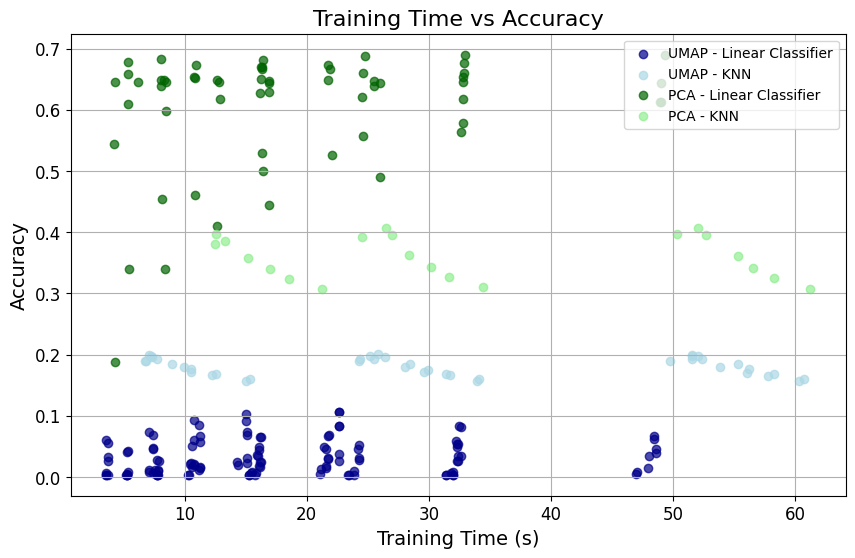

In [20]:
# Scatter plot for Training Time vs Accuracy
def scatter_plot_training_time_accuracy(df):
    colors = {
        ('UMAP', 'Linear Classifier'): 'darkblue',
        ('UMAP', 'KNN'): 'lightblue',
        ('PCA', 'Linear Classifier'): 'darkgreen',
        ('PCA', 'KNN'): 'lightgreen'
    }

    plt.figure(figsize=(10, 6))

    for (method, model), color in colors.items():
        subset_df = df[(df['Method'] == method) & (df['Model'] == model)]
        plt.scatter(subset_df['Training Time (s)'], subset_df['Accuracy'], color=color, label=f'{method} - {model}', alpha=0.7)

    plt.xlabel('Training Time (s)')
    plt.ylabel('Accuracy')
    plt.title('Training Time vs Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

scatter_plot_training_time_accuracy(df)


In [21]:
for method in ['UMAP', 'PCA']:
    subset_df = df[df['Method'] == method]['Reduction Time (s)']
    avg = subset_df.mean()
    print(f'The Average reduction time of {method} is {avg:.2f} seconds')

The Average reduction time of UMAP is 1637.65 seconds
The Average reduction time of PCA is 23.09 seconds


### Further analysis of PCA  results (chosen method)

In [22]:
pca_results_df = df[df['Method'] == 'PCA']

##### Analysing Linear Classifier Results

In [23]:
linear_df = pca_results_df[pca_results_df['Model'] == 'Linear Classifier']
linear_df = linear_df[['Parameters', 'Training Time (s)', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Learning Rate', 'Epochs', 'Epoch Losses', 'Epoch Accuracies']].reset_index()

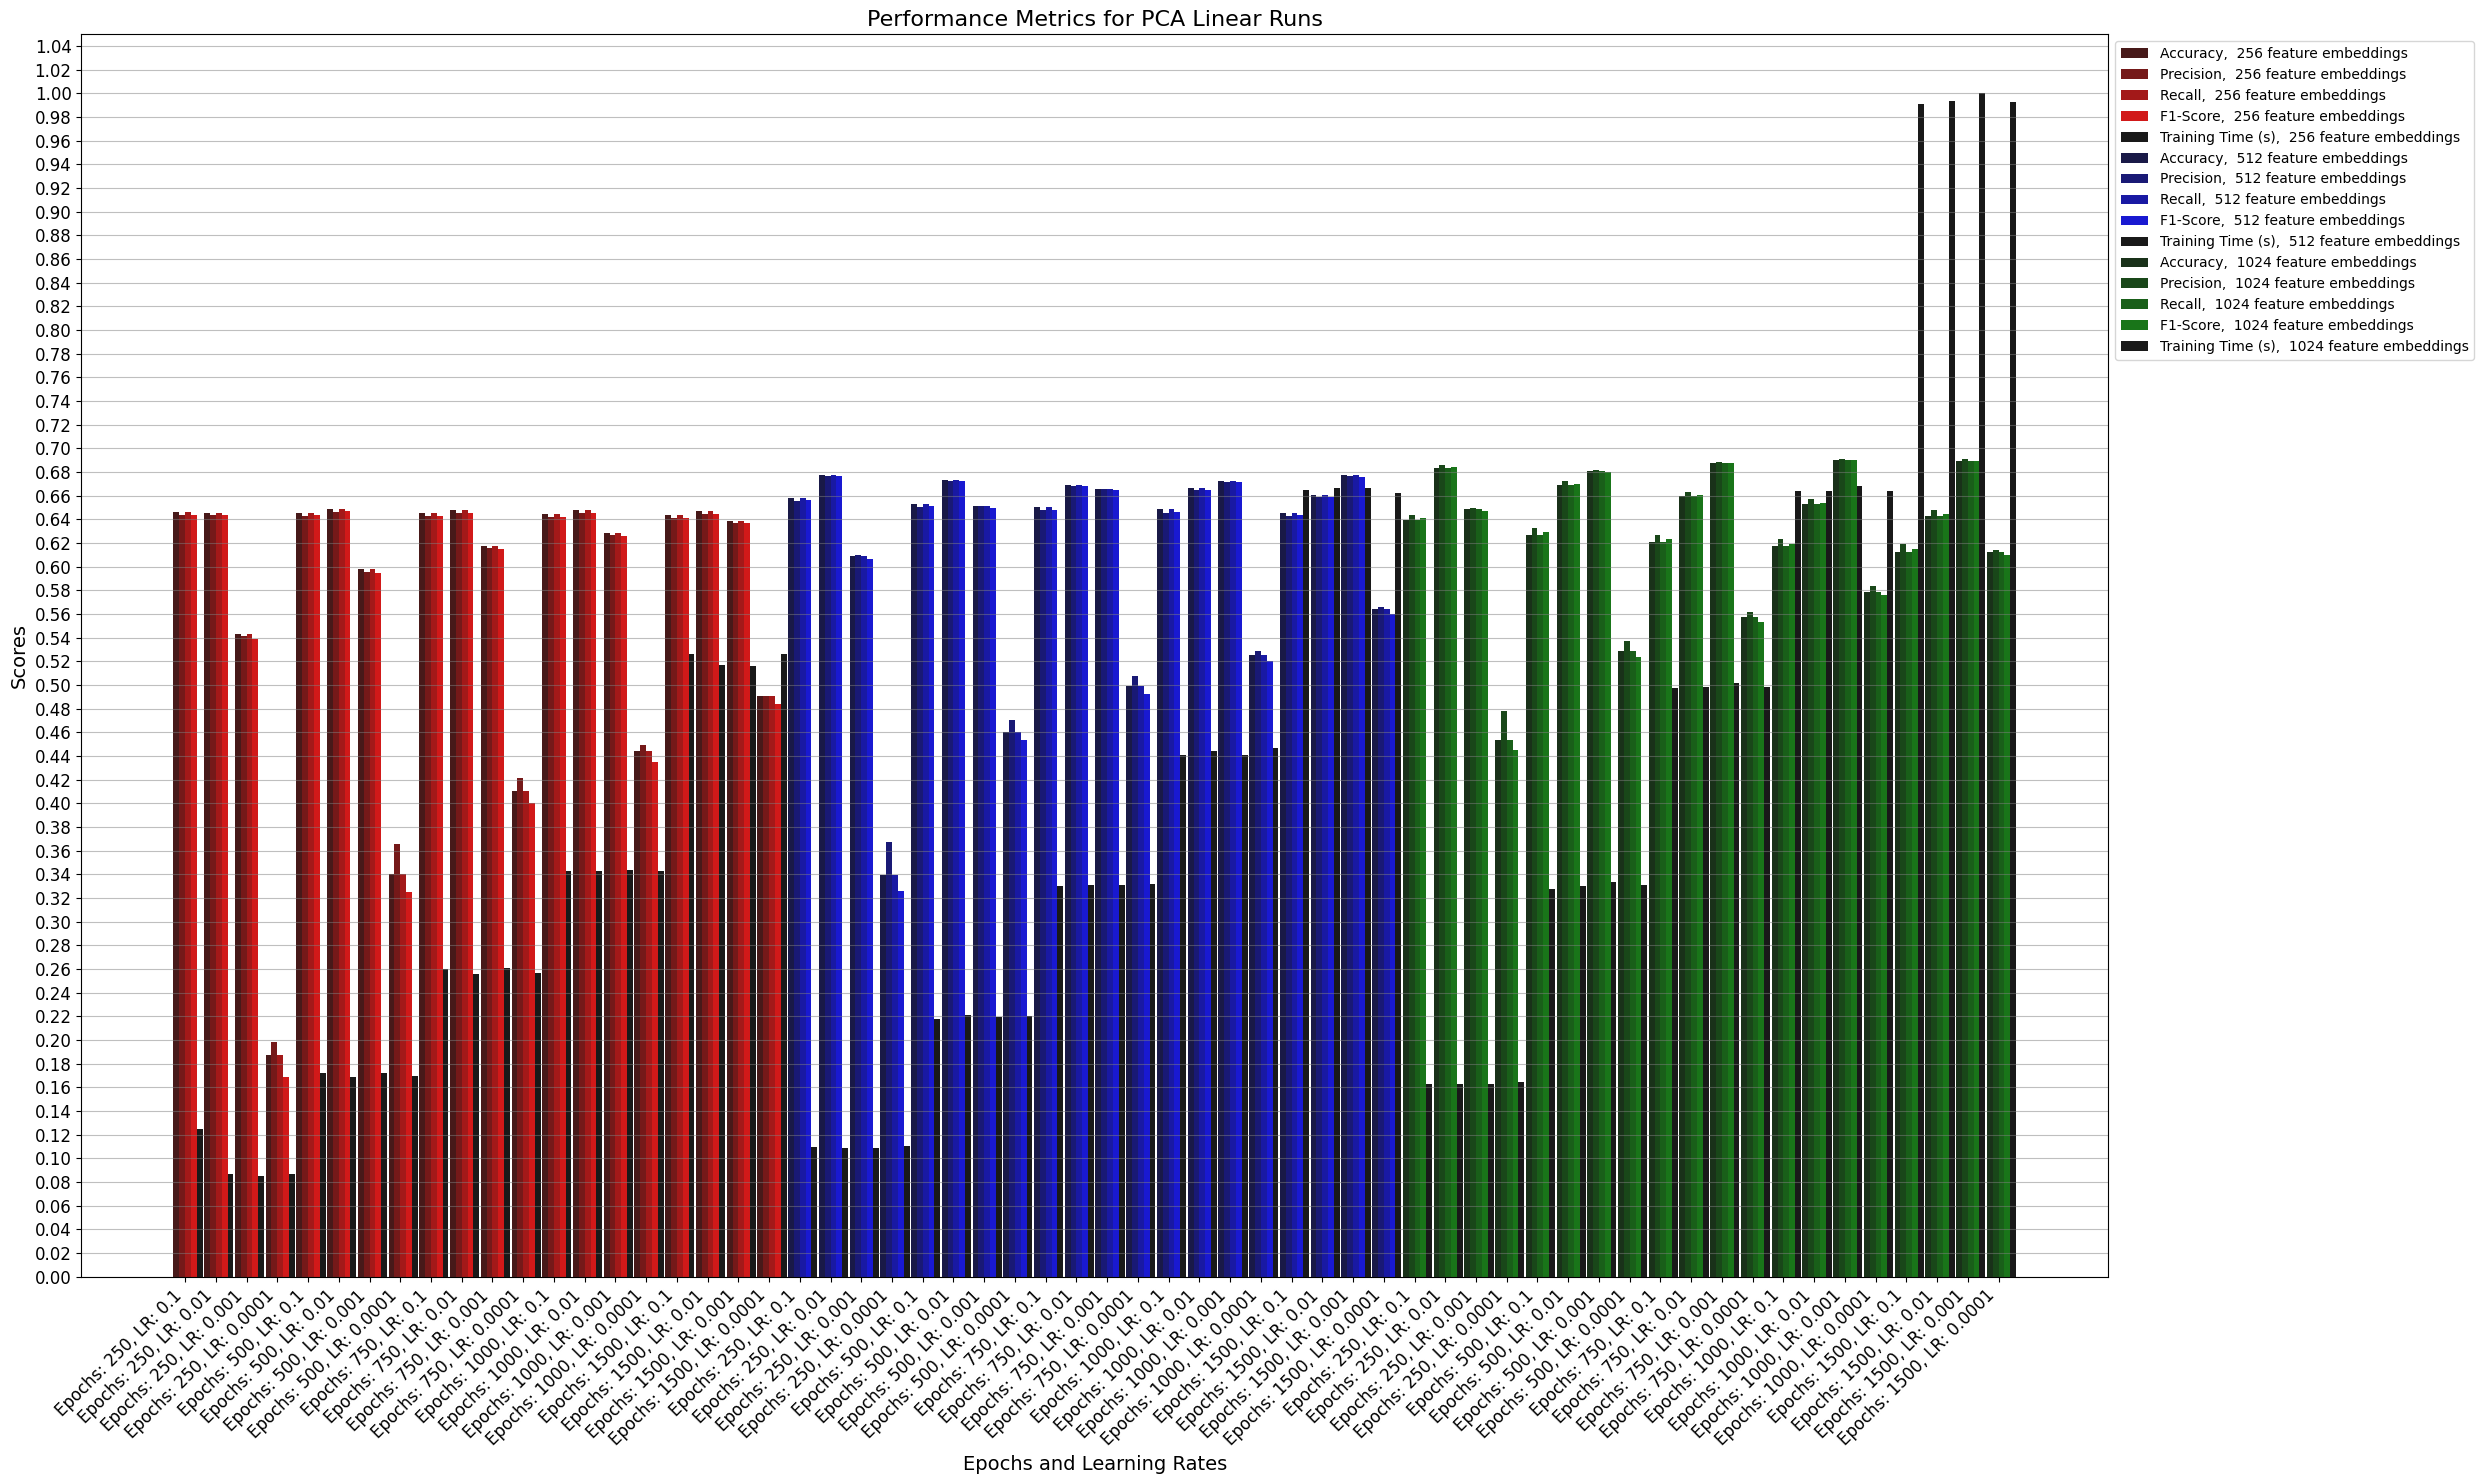

In [24]:
import matplotlib.colors as mcolors


def adjust_color_brightness(color, factor): 
    c = mcolors.to_rgb(color) 
    return (c[0] * factor, c[1] * factor, c[2] * factor)


# Farben für n_components
colors = {
    "{'n_components': 256, 'random_state': 42}": 'red',
    "{'n_components': 512, 'random_state': 42}": 'blue',
    "{'n_components': 1024, 'random_state': 42}": 'green'
}

# Erstellung des Diagramms
fig, ax = plt.subplots(figsize=(25, 15))

bar_width = 0.19
index = np.arange(len(linear_df))



metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)']
bar_positions = {
    'Accuracy': 0,
    'Precision': 1,
    'Recall': 2,
    'F1-Score': 3,
    'Training Time (s)': 4
}

highest_training_duration = max(linear_df['Training Time (s)'])


basecolor_old = None
added_labels = set()

for i, row in linear_df.iterrows():

    basecolor = colors[row['Parameters']]

    if basecolor == 'red': comp = 256
    elif basecolor == 'blue': comp = 512
    elif basecolor == 'green': comp = 1024


    for metric in metrics:

        label_text = f'{metric},  {comp} feature embeddings'
        label = label_text if label_text not in added_labels else None
        if label:
            added_labels.add(label_text)

        ax.bar(
            i + bar_positions[metric] * bar_width, 
            row[metric] / highest_training_duration if metric == 'Training Time (s)' else row[metric],
            width=bar_width,
            label=label,
            color=adjust_color_brightness(basecolor, ((bar_positions[metric]+1) % 5)*0.2), # setting color for Time to black (modulo 5 = 0)
            alpha=0.9
        )
        #print(f'{metric}: ', row[metric] / highest_training_duration if metric =)
        

# X-Achsenbeschriftung
xtick_labels = [f'Epochs: {int(ep)}, LR: {lr}' for ep, lr in zip(linear_df['Epochs'], linear_df['Learning Rate'])]
ax.set_xlabel('Epochs and Learning Rates')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics for PCA Linear Runs')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

# # Legende
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper left', bbox_to_anchor=(1, 1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.02))
ax.grid(axis='y', which='major', linestyle='-', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()


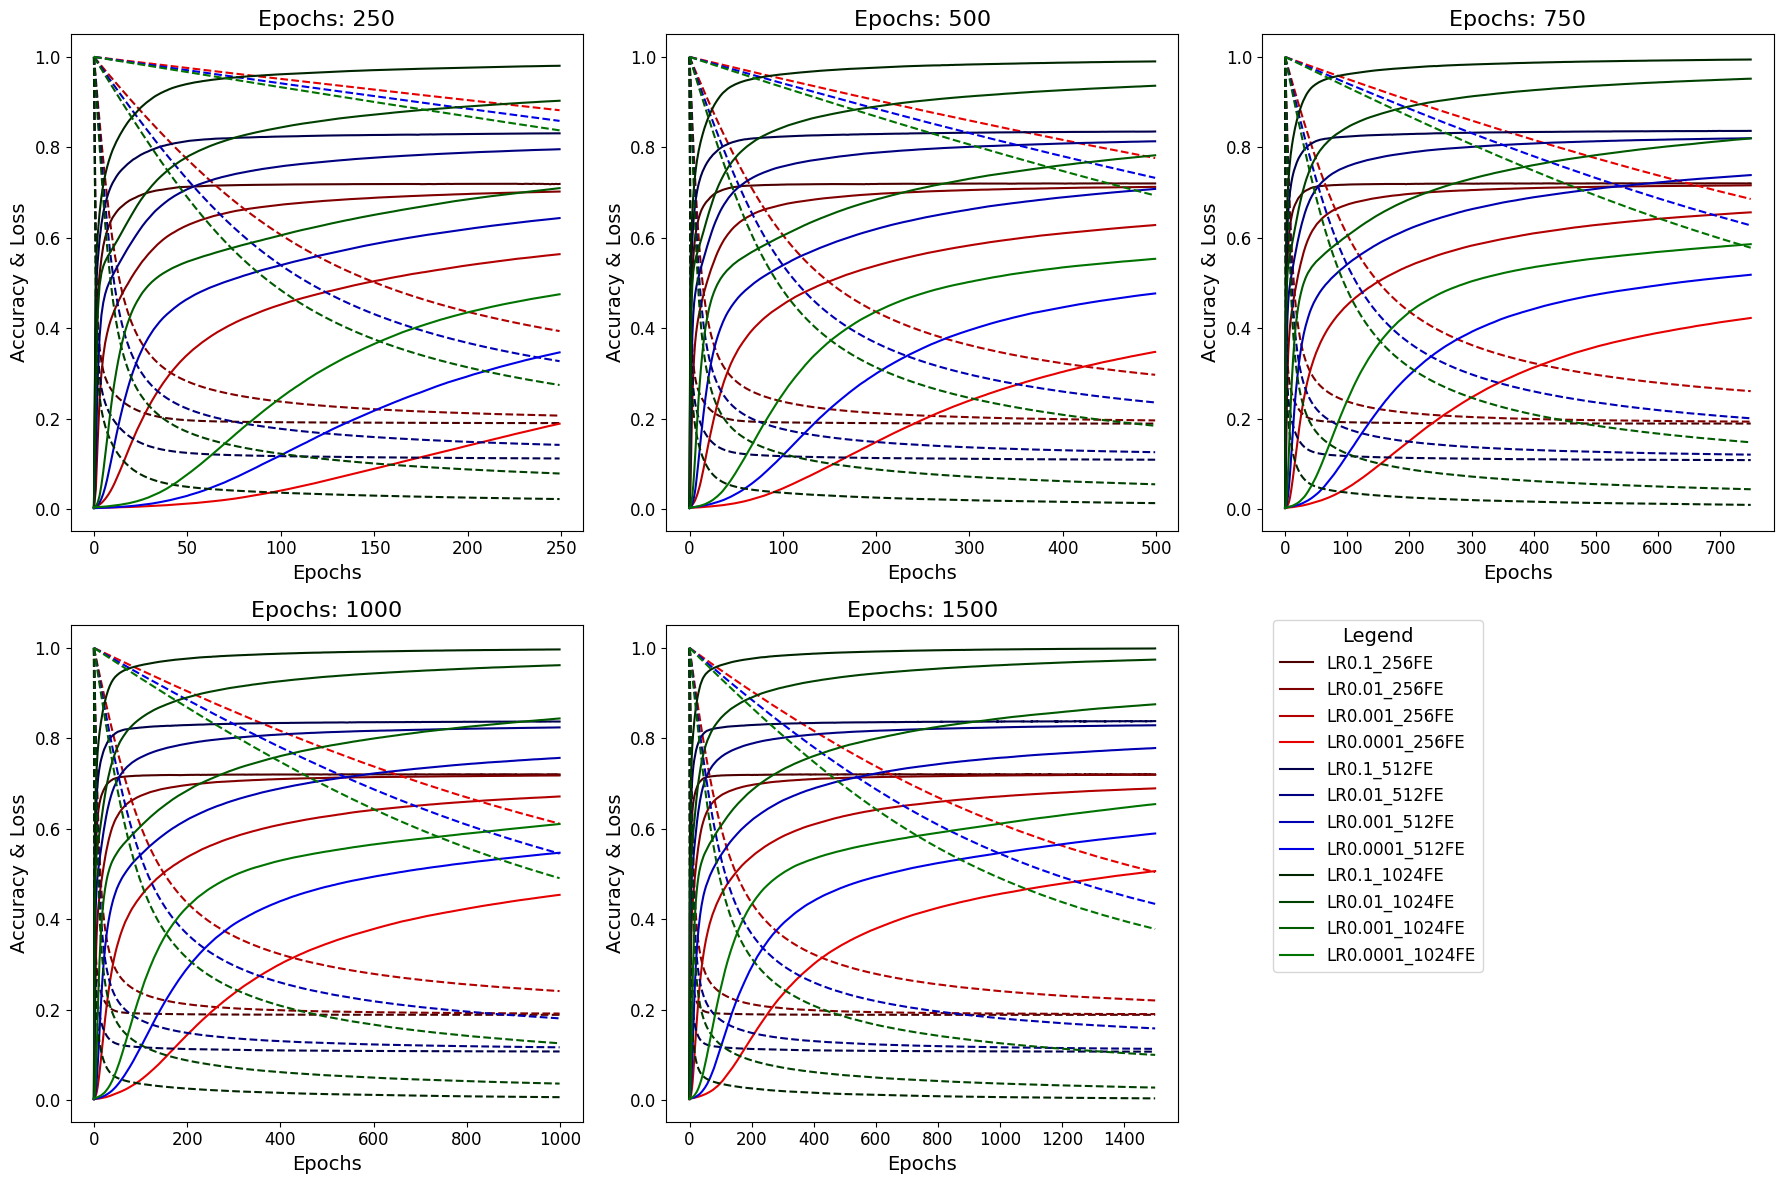

In [25]:
# Finde einzigartige Epochs
unique_epochs = linear_df['Epochs'].unique()

# Erstellen des Plots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Farben für die Linien
colors = {
    'lr0.1_256fe': adjust_color_brightness('red', 0.3),
    'lr0.01_256fe': adjust_color_brightness('red', 0.5),
    'lr0.001_256fe': adjust_color_brightness('red', 0.7),
    'lr0.0001_256fe': adjust_color_brightness('red', 0.9),
    'lr0.1_512fe': adjust_color_brightness('blue', 0.3),
    'lr0.01_512fe': adjust_color_brightness('blue', 0.5),
    'lr0.001_512fe': adjust_color_brightness('blue', 0.7),
    'lr0.0001_512fe': adjust_color_brightness('blue', 0.9),
    'lr0.1_1024fe': adjust_color_brightness('green', 0.3),
    'lr0.01_1024fe': adjust_color_brightness('green', 0.5),
    'lr0.001_1024fe': adjust_color_brightness('green', 0.7),
    'lr0.0001_1024fe': adjust_color_brightness('green', 0.9)
}

# Zeichnen der Linienplots
for idx, epoch in enumerate(unique_epochs):
    epoch = int(epoch)
    ax = axs[idx//3, idx%3]
    runs = linear_df[linear_df['Epochs'] == epoch].reset_index()
    for i, run in runs.iterrows():
        epoch_losses = eval(run['Epoch Losses'])  # Eval for list of losses
        epoch_losses_max = max(epoch_losses)
        epoch_losses = [loss / epoch_losses_max for loss in epoch_losses]
        epoch_accuracies = eval(run['Epoch Accuracies'])  # Eval for list of accuracies
        
        ax.plot(epoch_losses, linestyle='--', color=list(colors.values())[i])
        ax.plot(epoch_accuracies, label=f'{list(colors.keys())[i].upper()}', linestyle='-', color=list(colors.values())[i])
    
    ax.set_title(f'Epochs: {epoch}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy & Loss')

# Remove the unused 6th axis
fig.delaxes(axs[1, 2])

# Create a shared legend in the position of the removed axis
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.77, 0.33), title="Legend", fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()


##### Analysing KNN Results

In [26]:
knn_df = pca_results_df[pca_results_df['Model'] == 'KNN']
knn_df = knn_df[['Parameters', 'Training Time (s)', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Neighbors']].reset_index()

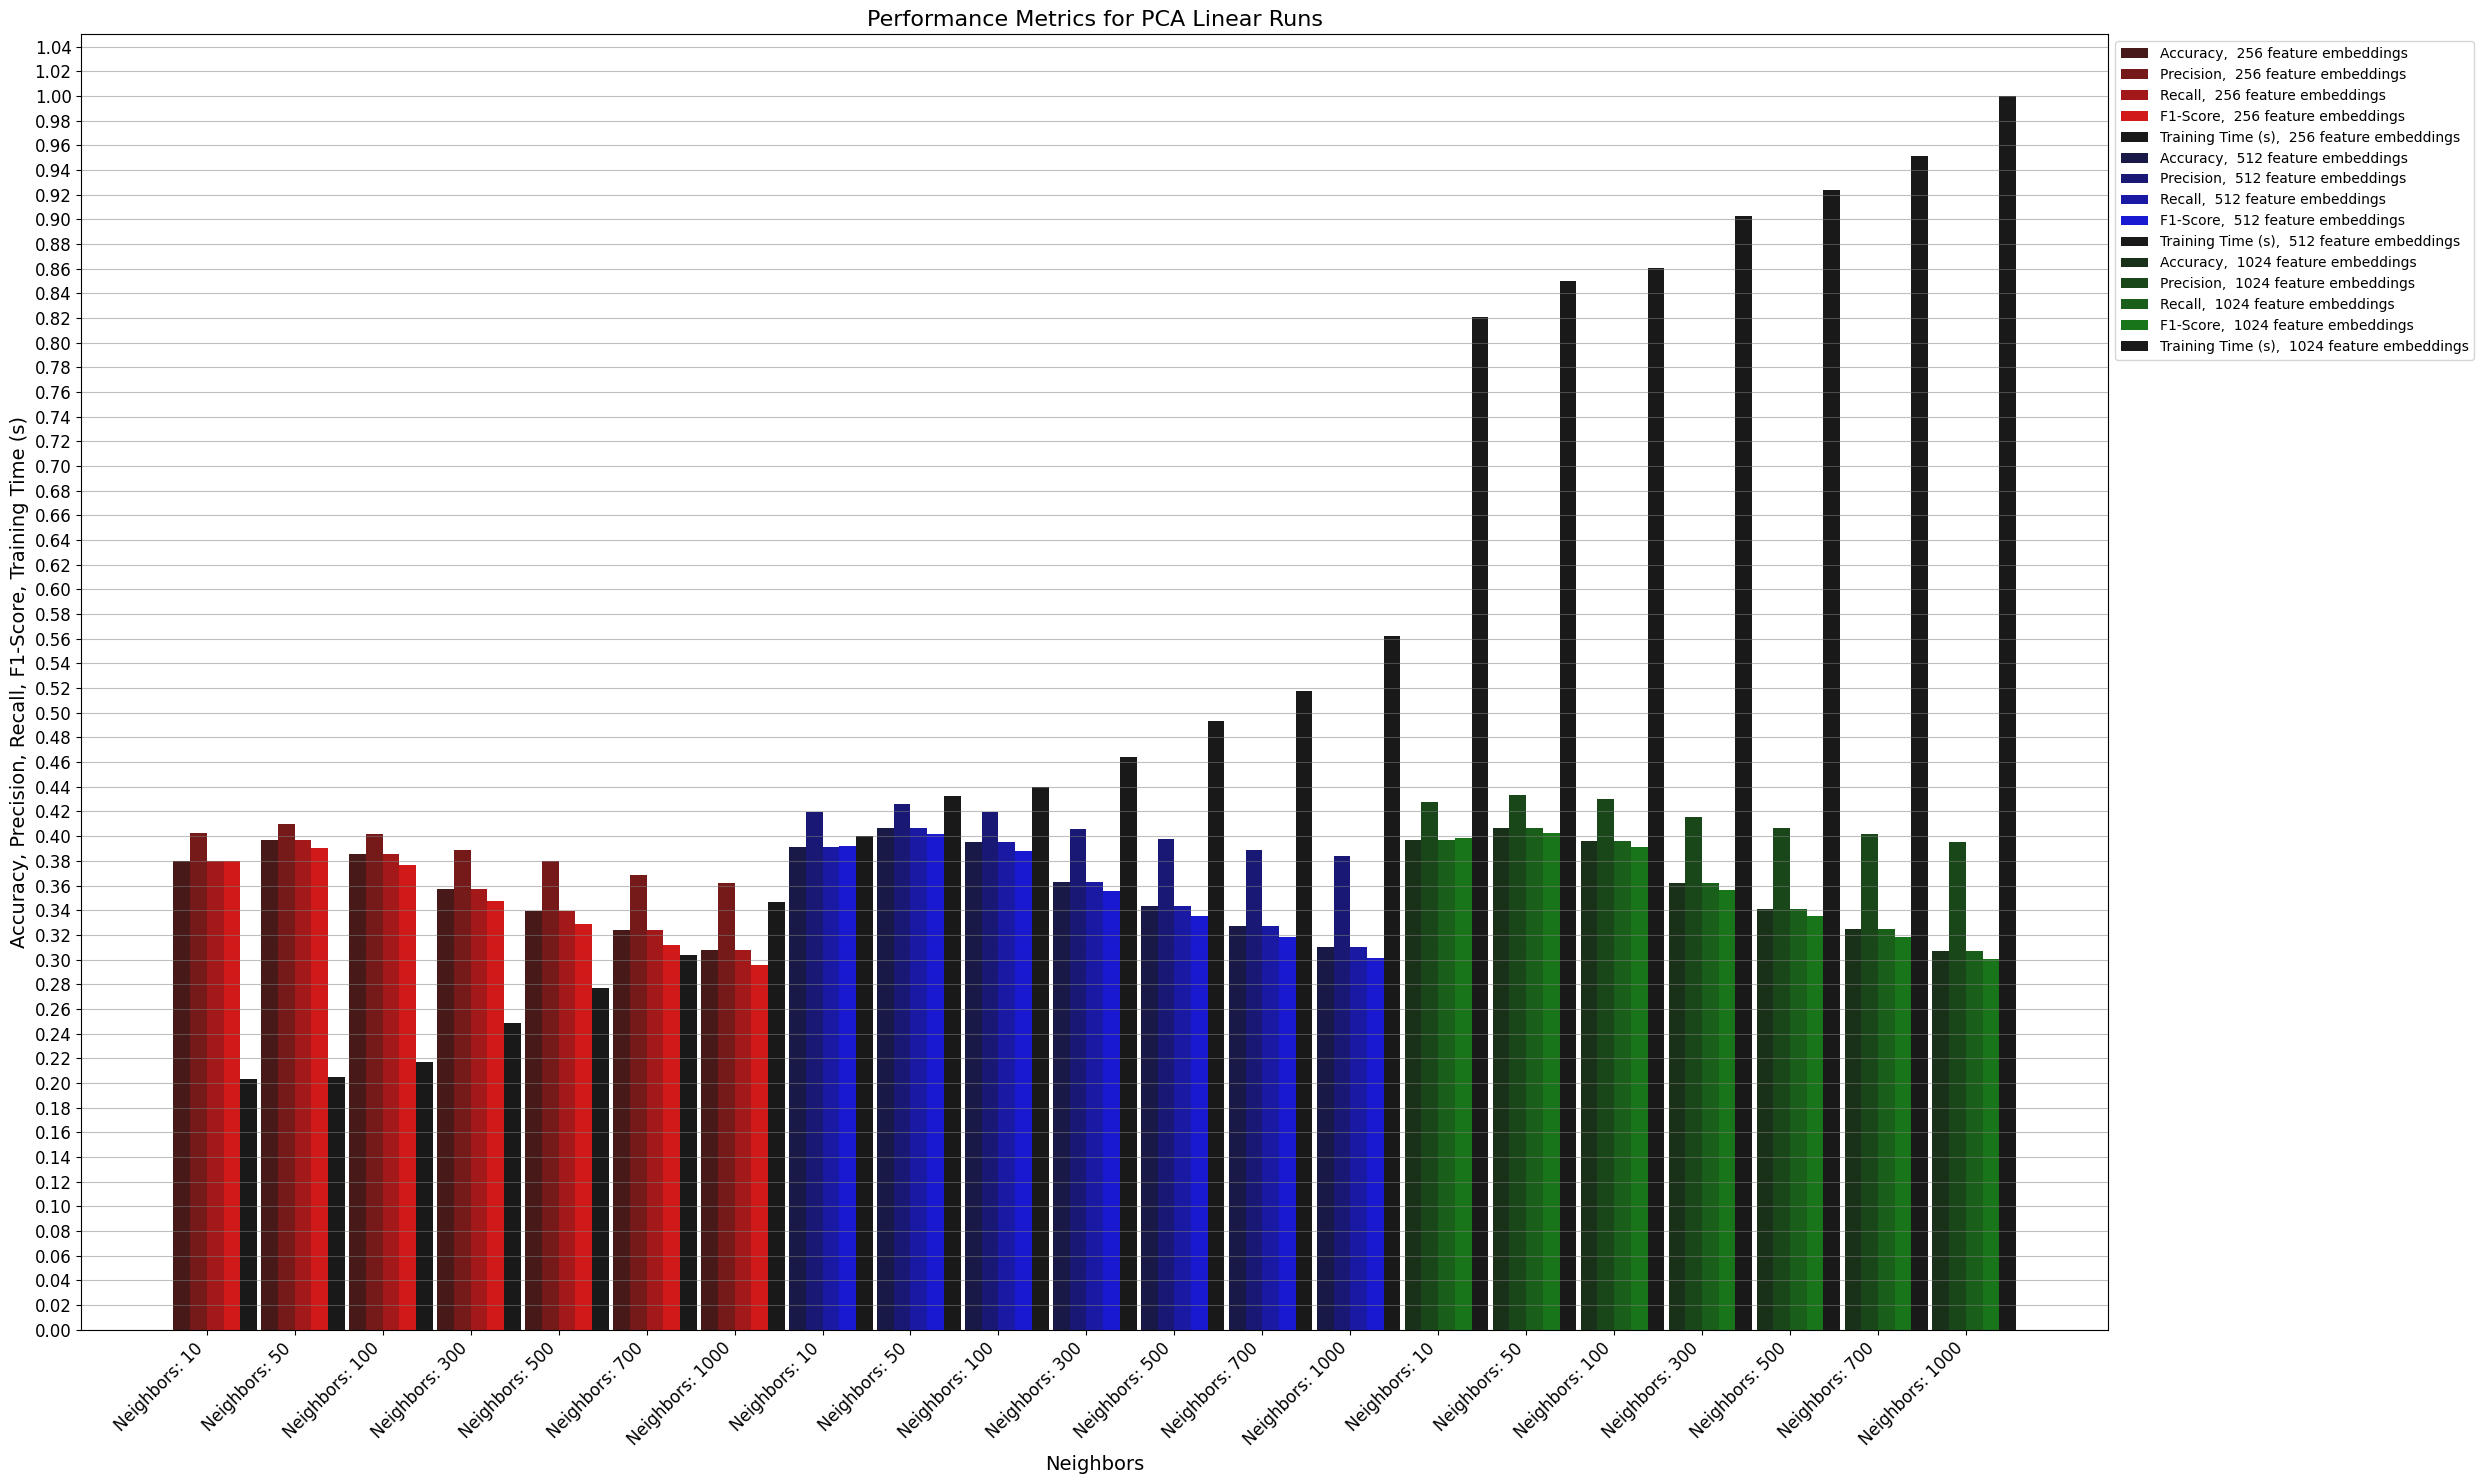

In [27]:
import matplotlib.colors as mcolors


def adjust_color_brightness(color, factor): 
    c = mcolors.to_rgb(color) 
    return (c[0] * factor, c[1] * factor, c[2] * factor)


# Farben für n_components
colors = {
    "{'n_components': 256, 'random_state': 42}": 'red',
    "{'n_components': 512, 'random_state': 42}": 'blue',
    "{'n_components': 1024, 'random_state': 42}": 'green'
}

# Erstellung des Diagramms
fig, ax = plt.subplots(figsize=(25, 15))

bar_width = 0.19
index = np.arange(len(knn_df))



metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)']
bar_positions = {
    'Accuracy': 0,
    'Precision': 1,
    'Recall': 2,
    'F1-Score': 3,
    'Training Time (s)': 4
}

highest_training_duration = max(knn_df['Training Time (s)'])

basecolor_old = None
added_labels = set()

# Balken zeichnen
for i, row in knn_df.iterrows():

    basecolor = colors[row['Parameters']]

    if basecolor == 'red': comp = 256
    elif basecolor == 'blue': comp = 512
    elif basecolor == 'green': comp = 1024

    for metric in metrics:

        label_text = f'{metric},  {comp} feature embeddings'
        
        # Add label only if it hasn't been added before
        label = label_text if label_text not in added_labels else None
        if label:
            added_labels.add(label_text)

        ax.bar(
            i + bar_positions[metric] * bar_width, 
            row[metric] / highest_training_duration if metric == 'Training Time (s)' else row[metric],
            width=bar_width,
            label=label,
            color=adjust_color_brightness(basecolor, ((bar_positions[metric]+1) % 5)*0.2), # setting color for Time to black (modulo 5 = 0)
            alpha=0.9
        )        

# X-Achsenbeschriftung
xtick_labels = [f'Neighbors: {int(neighbors)}' for neighbors in knn_df['Neighbors']]
ax.set_xlabel('Neighbors')
ax.set_ylabel('Accuracy, Precision, Recall, F1-Score, Training Time (s)')
ax.set_title('Performance Metrics for PCA Linear Runs')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

# # Legende
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper left', bbox_to_anchor=(1, 1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.02))
ax.grid(axis='y', which='major', linestyle='-', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()
